Fake and Real News Detection using LSTM





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from datetime import datetime
from dateutil.parser import parse
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# setting seaborn style
sns.set()
sns.set_style('white')
sns.set_palette(sns.color_palette('gnuplot2'))
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.close()

Load Data

In [ ]:
df_fake = pd.read_csv('https://raw.githubusercontent.com/goshACA/fake-news/main/Fake.csv')
df_fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [ ]:
df_true = pd.read_csv('https://raw.githubusercontent.com/goshACA/fake-news/main/True.csv')
df_true.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


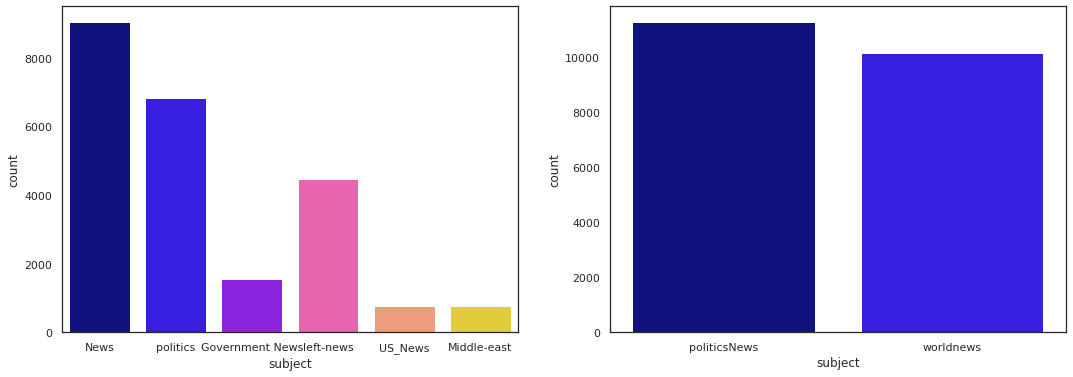

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(18,6))
sns.countplot(x='subject', data = df_fake, ax=ax[0])
sns.countplot(x='subject', data = df_true, ax=ax[1])

Let's visualize the length of fake articles based on the published date.

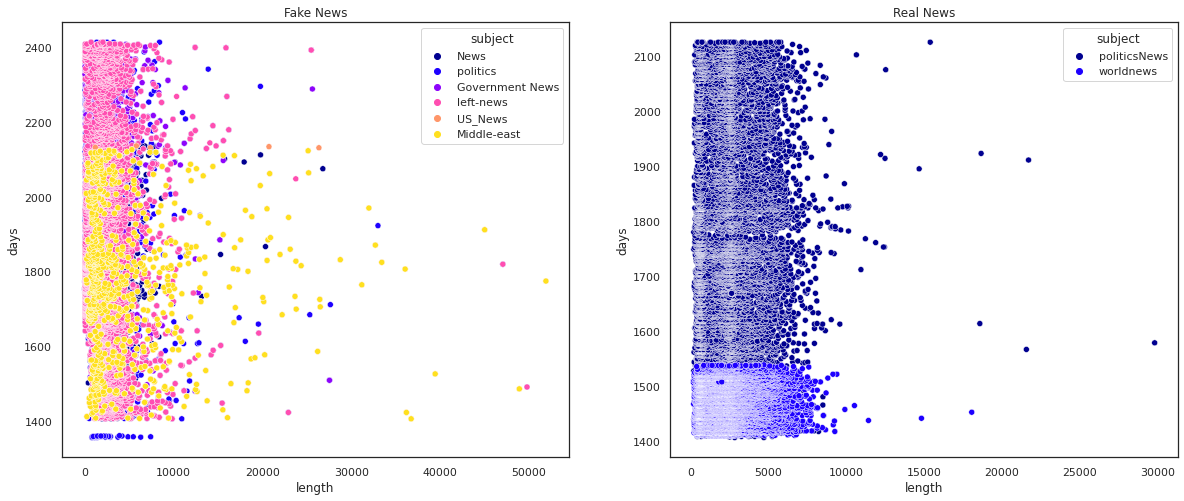

In [180]:
def parse_to_days(date):
  try:
    return (datetime.now() - parse(date)).days
  except :
    pass

df_fake['length'] = [len(text) for text in df_fake['text']]
df_fake['days'] = [parse_to_days(date) for date in df_fake['date']]
df_fake['has_text'] = [len(x.replace(" ", ""))>0 for x in df_fake['text']]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.title.set_text('Fake News')
sns.scatterplot(x = 'length', y = 'days' , hue = 'subject', data = df_fake, ax=ax1)

df_true['length'] = [len(text) for text in df_true['text']]
df_true['days'] = [parse_to_days(date) for date in df_true['date']]
df_true['has_text'] = [len(x.replace(" ", ""))>0 for x in df_true['text']]

ax2.title.set_text('Real News')
sns.scatterplot(x = 'length', y = 'days' , hue = 'subject', data = df_true, ax=ax2)

WordCloud

In [ ]:
text_f = ' '.join(df_fake['text'].tolist())
text_t = ' '.join(df_true['text'].tolist())

In [ ]:
wcloud_f = WordCloud().generate(text_f)
wcloud_t = WordCloud().generate(text_t)

In [ ]:
def plot_cloud(wordcloud):
  fig = plt.figure(figsize=(15, 15))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()  

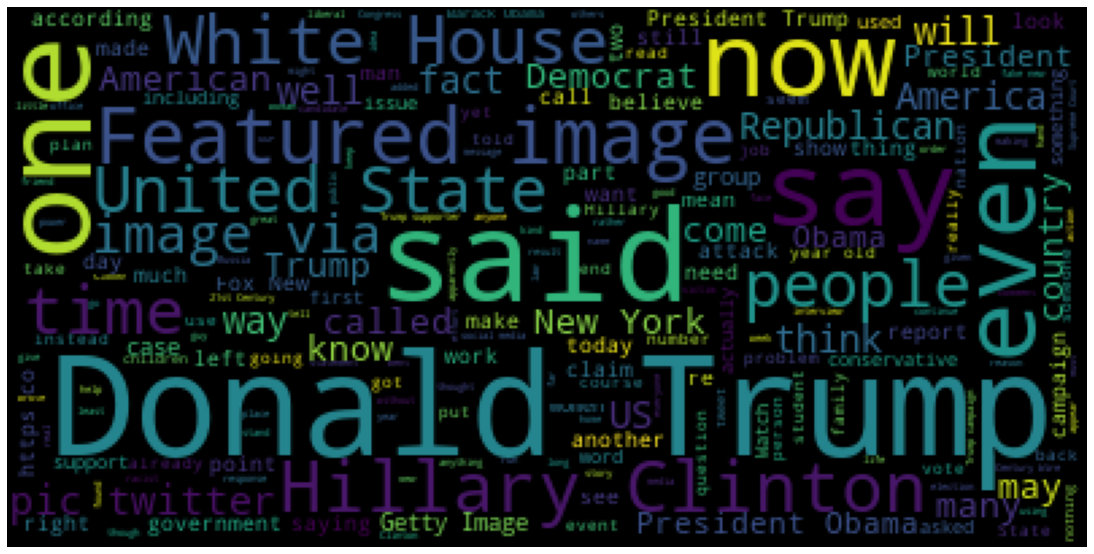

In [ ]:
plot_cloud(wcloud_f)

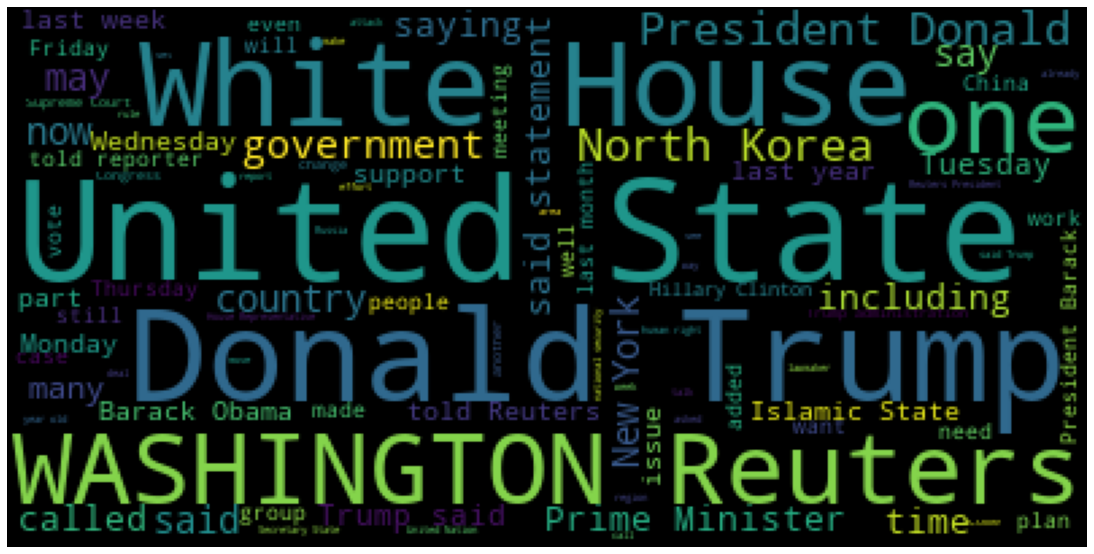

In [ ]:
plot_cloud(wcloud_t)

Based on the two clouds we can observe that:
1. Fake news dont include publishers' name (such as Washington Reuters)
2. There are many fake news taken from twitter

## Cleaning Data
There are few steps needed to clean the data and prepare to processing:
1. drop real news with empty texts
1. remove information from unknown publishers
2. check if text description is included in the title and concatenate titles to texts to not loose data
3. remove special characters from texts 


In [ ]:
df_true = df_true[df_true.text.replace(" ", "") != ""]

In [ ]:
unknown_pubs = []
for i, row in enumerate(df_true['text'].values):
  try:
    record = row.split(' - ', maxsplit = 1)
    assert(len(record[0]) < 280)
    assert(record[1])
  except:
    unknown_pubs.append(i)

In [ ]:
print('Amount of unknown publishers: ', len(unknown_pubs))

Amount of unknown publishers:  34


In [ ]:
pubs = []
tmp_text = []

for i, row in enumerate(df_true['text'].values):
  if i in unknown_pubs:
    tmp_text.append(row)
    pubs.append('Unknown')

  else:
    rec = row.split(' - ', maxsplit = 1)
    pubs.append(rec[0])
    tmp_text.append(rec[1])

In [ ]:
df_true['pub'] = pubs
df_true['text'] = tmp_text

In [ ]:
print(df_true.shape)
print(df_fake.shape)

(21416, 8)
(23481, 9)


In [ ]:
empty_fake_loc = [i for i, text in enumerate(df_fake.text.tolist()) if text.replace(" ", "") == ""]

In [ ]:
df_fake.iloc[empty_fake_loc]

,title,text,subject,date,length,days,has_title,has_text,years
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",1,1642.0,True,False,2017
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",1,1656.0,True,False,2017
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",1,1676.0,True,False,2017
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",1,1680.0,True,False,2017
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017",1,1681.0,True,False,2017
...,...,...,...,...,...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",1,2386.0,True,False,2015
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",1,2388.0,True,False,2015
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",1,2388.0,True,False,2015
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",1,2399.0,True,False,2015


As we can see the title contains also the description of fake news, so to not loose the data, we can concatenate title and text in the text column

In [ ]:
df_true['text'] = (df_true['title'] + ' ' + df_true['text']).str.lower()
df_fake['text'] = (df_fake['title'] + ' ' + df_fake['text']).str.lower()

## Preprocessing Data

In [ ]:
df_true['class'] = 1
df_fake['class'] = 0

Removing special characters

In [ ]:
data = df_true[['text', 'class']].append(df_fake[['text', 'class']])
data.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [ ]:
data['text'] = data['text'].apply(lambda x: re.sub('[!,:*)-@#%(&"$_?.$^]', '', x))
data

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator 'let mr mueller d...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
23476,mcpain john mccain furious that iran treated u...,0
23477,justice yahoo settles email privacy classactio...,0
23478,sunnistan us and allied ‘safe zone’ plan to ta...,0
23479,how to blow million al jazeera america finall...,0


## Vectorization
To be able to process the news we have to use vectorization technique to get word embeddings.

In [ ]:
import gensim

In [ ]:
y = data['class'].values
X = [d.split() for d in data['text'].tolist()]

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
X

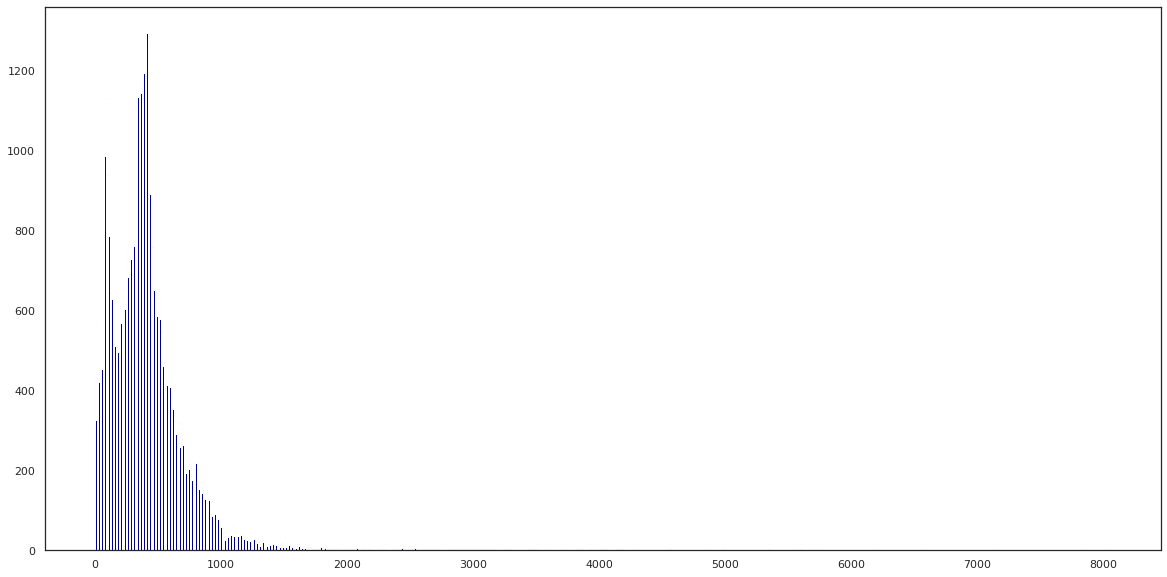

In [ ]:
#fig = plt.figure(figsize=(10, 8))
plt.figure(figsize=(10,8))
plt.hist([len(x) for x in X], bins=700)
plt.show()

Lets pad sentences in the news data to get fixed size length.

In [ ]:
nums = np.array([len(x) for x in X])
max_length = 1000
X = pad_sequences(X, maxlen=max_length)

In [ ]:
def get_weight_matrix(model):
  vocab_size = len(tokenizer.word_index) + 1
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in tokenizer.word_index.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
embeddings = get_weight_matrix(w2v_model)
embeddings

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

After getting embeddings we can create a model using LSTM. 

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, output_dim=DIM, weights=[embeddings], input_length=max_length))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
hist = model.fit(X_train, y_train, validation_split=0.3, epochs=15, callbacks=[es, reduce_lr])

Epoch 1/15
737/737 [==============================] - 142s 183ms/step - loss: 0.1571 - accuracy: 0.9412 - val_loss: 0.0658 - val_accuracy: 0.9795
Epoch 2/15
737/737 [==============================] - 134s 181ms/step - loss: 0.0529 - accuracy: 0.9814 - val_loss: 0.0529 - val_accuracy: 0.9814
Epoch 3/15
737/737 [==============================] - 133s 181ms/step - loss: 0.0270 - accuracy: 0.9911 - val_loss: 0.0858 - val_accuracy: 0.9722
Epoch 4/15
737/737 [==============================] - 133s 181ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0196 - val_accuracy: 0.9943
Epoch 5/15
737/737 [==============================] - 134s 182ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0243 - val_accuracy: 0.9938
Epoch 6/15
737/737 [==============================] - 134s 182ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0333 - val_accuracy: 0.9880
Epoch 7/15
737/737 [==============================] - 134s 182ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0233 -

In [177]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)
clf_report = classification_report(y_test, y_pred, output_dict=True)

In [170]:
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: \n", clf_report)

Accuracy score:  0.9959910913140312
Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      5836
           1       0.99      1.00      1.00      5389

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



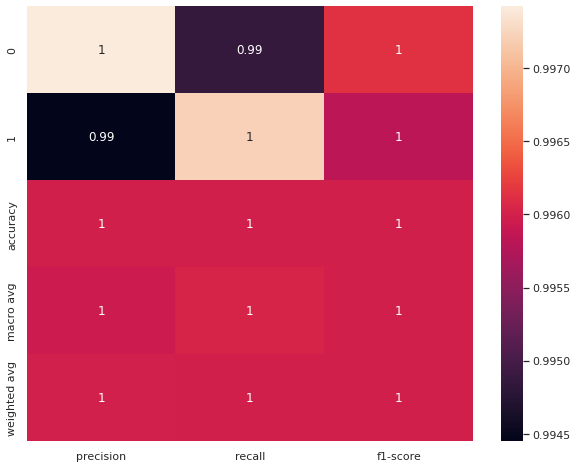

In [179]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

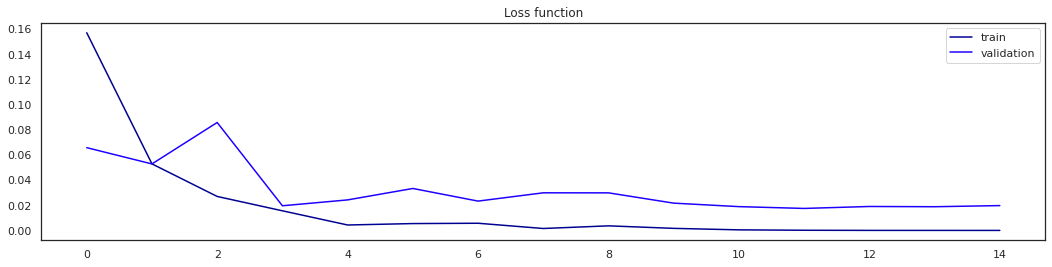

In [171]:
plt.figure(figsize=(18,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss function')
plt.show()

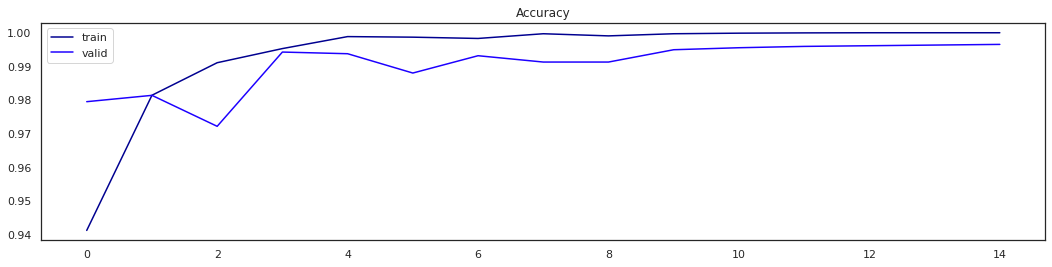

In [172]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()